## esto es ya processing, hay que ver donde meterlo

In [29]:
import os
import pandas as pd
import librosa as lbrs
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import shutil
import noisereduce as nr

In [30]:
WINDOW_SEC=3

In [31]:
## Load oggs into wav format, chop them, save them in class folder in database/assets/wav

# defining params

csv_path = os.path.join(os.pardir, 'database', 'meta', 'train_data.csv') # ../database/meta/train_data.csv
abs_csv_path = os.path.abspath(csv_path)    # /home/.../database/meta/train_data.csv
train_data=pd.read_csv(abs_csv_path)

output_dir = os.path.join(os.pardir, 'database', 'assets', 'wav') 
output_dir = os.path.abspath(output_dir) 

input_dir = os.path.join(os.pardir, 'database', 'assets', 'raw')
input_dir = os.path.abspath(input_dir)

# clear out wav folder
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# action below

for row in train_data.itertuples(index=False):
    filename = row.filename
    class_id = row.class_id
    audio_path = os.path.join(input_dir, filename)
    
    wav, srate = lbrs.load(audio_path, sr=None)
    duration = len(wav) / srate
    if duration <   WINDOW_SEC:
        continue  # Skip short audio files
    wav_windows = [wav[i:i+WINDOW_SEC * srate]
                   for i in range(0, len(wav), WINDOW_SEC * srate)   ]
    
    class_dir = os.path.join(output_dir, str(class_id))
    os.makedirs(class_dir, exist_ok=True)
    for w in range(0,len(wav_windows)):
        # Save each windowed audio segment
        w_filename = f"{filename.replace('.ogg', '')}_{w}.wav"
        w_path = os.path.join(class_dir, w_filename)
        sf.write(w_path, wav_windows[w], srate)


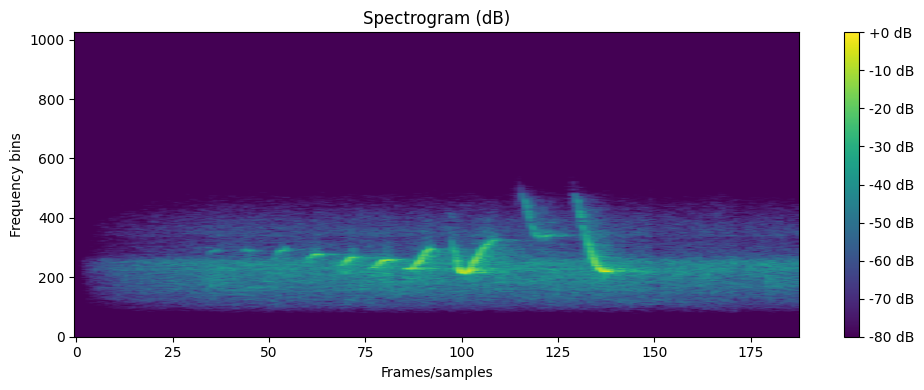

In [32]:
canto,_=lbrs.load(os.path.join(output_dir, '0', 'XC52510_0.wav'), sr=None)  # Load a specific audio file

# para hacer ffourier es necesario que pajaro sea de tipo np.ndarray
canto = np.asarray(canto)

# fourier -> espectograma en db -> grafico

ffourier=lbrs.stft(canto)
S_db = lbrs.amplitude_to_db(np.abs(ffourier), ref=np.max)          # spectogram in dB

plt.figure(figsize=(10, 4))
plt.imshow(S_db, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.xlabel('Frames/samples')
plt.ylabel('Frequency bins')
plt.tight_layout()
plt.show()

In [33]:
# calculo de energia para este canto. revisar hop
hoplen=1
rms = lbrs.feature.rms(S=ffourier, hop_length=hoplen)  # root-mean-square value for each window, hop-length es la cantidad de frames de audio que se usan para calcular cada valor de energía
print("La energia de este canto en cada ventana de", hoplen,"frames es en promedio =", np.mean(rms))
print("La suma de las energías =", np.sum(rms))

La energia de este canto en cada ventana de 1 frames es en promedio = 0.022725367055950567
La suma de las energías = 4.272369006518707


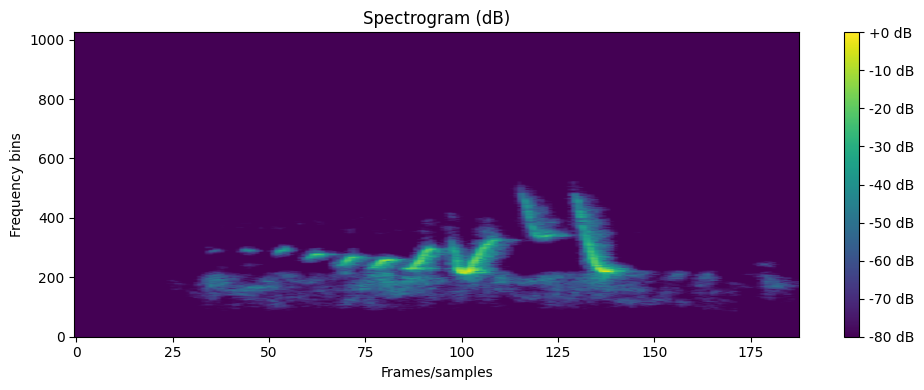

La energia de este canto con noise reduction en cada ventana de 1 frames es en promedio = 0.011092961009332417
La suma de las energías con noise reduction = 2.0854766697544944


In [34]:
nr_canto=nr.reduce_noise(canto, sr=32000, stationary=False)  # Reduce noise in the audio signal

ffourier=lbrs.stft(nr_canto)
S_db = lbrs.amplitude_to_db(np.abs(ffourier), ref=np.max)          # spectogram in dB

plt.figure(figsize=(10, 4))
plt.imshow(S_db, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.xlabel('Frames/samples')
plt.ylabel('Frequency bins')
plt.tight_layout()
plt.show()

rms= lbrs.feature.rms(S=ffourier, hop_length=hoplen)
print("La energia de este canto con noise reduction en cada ventana de", hoplen,"frames es en promedio =", np.mean(rms))
print("La suma de las energías con noise reduction =", np.sum(rms))


<Figure size 2500x1000 with 0 Axes>

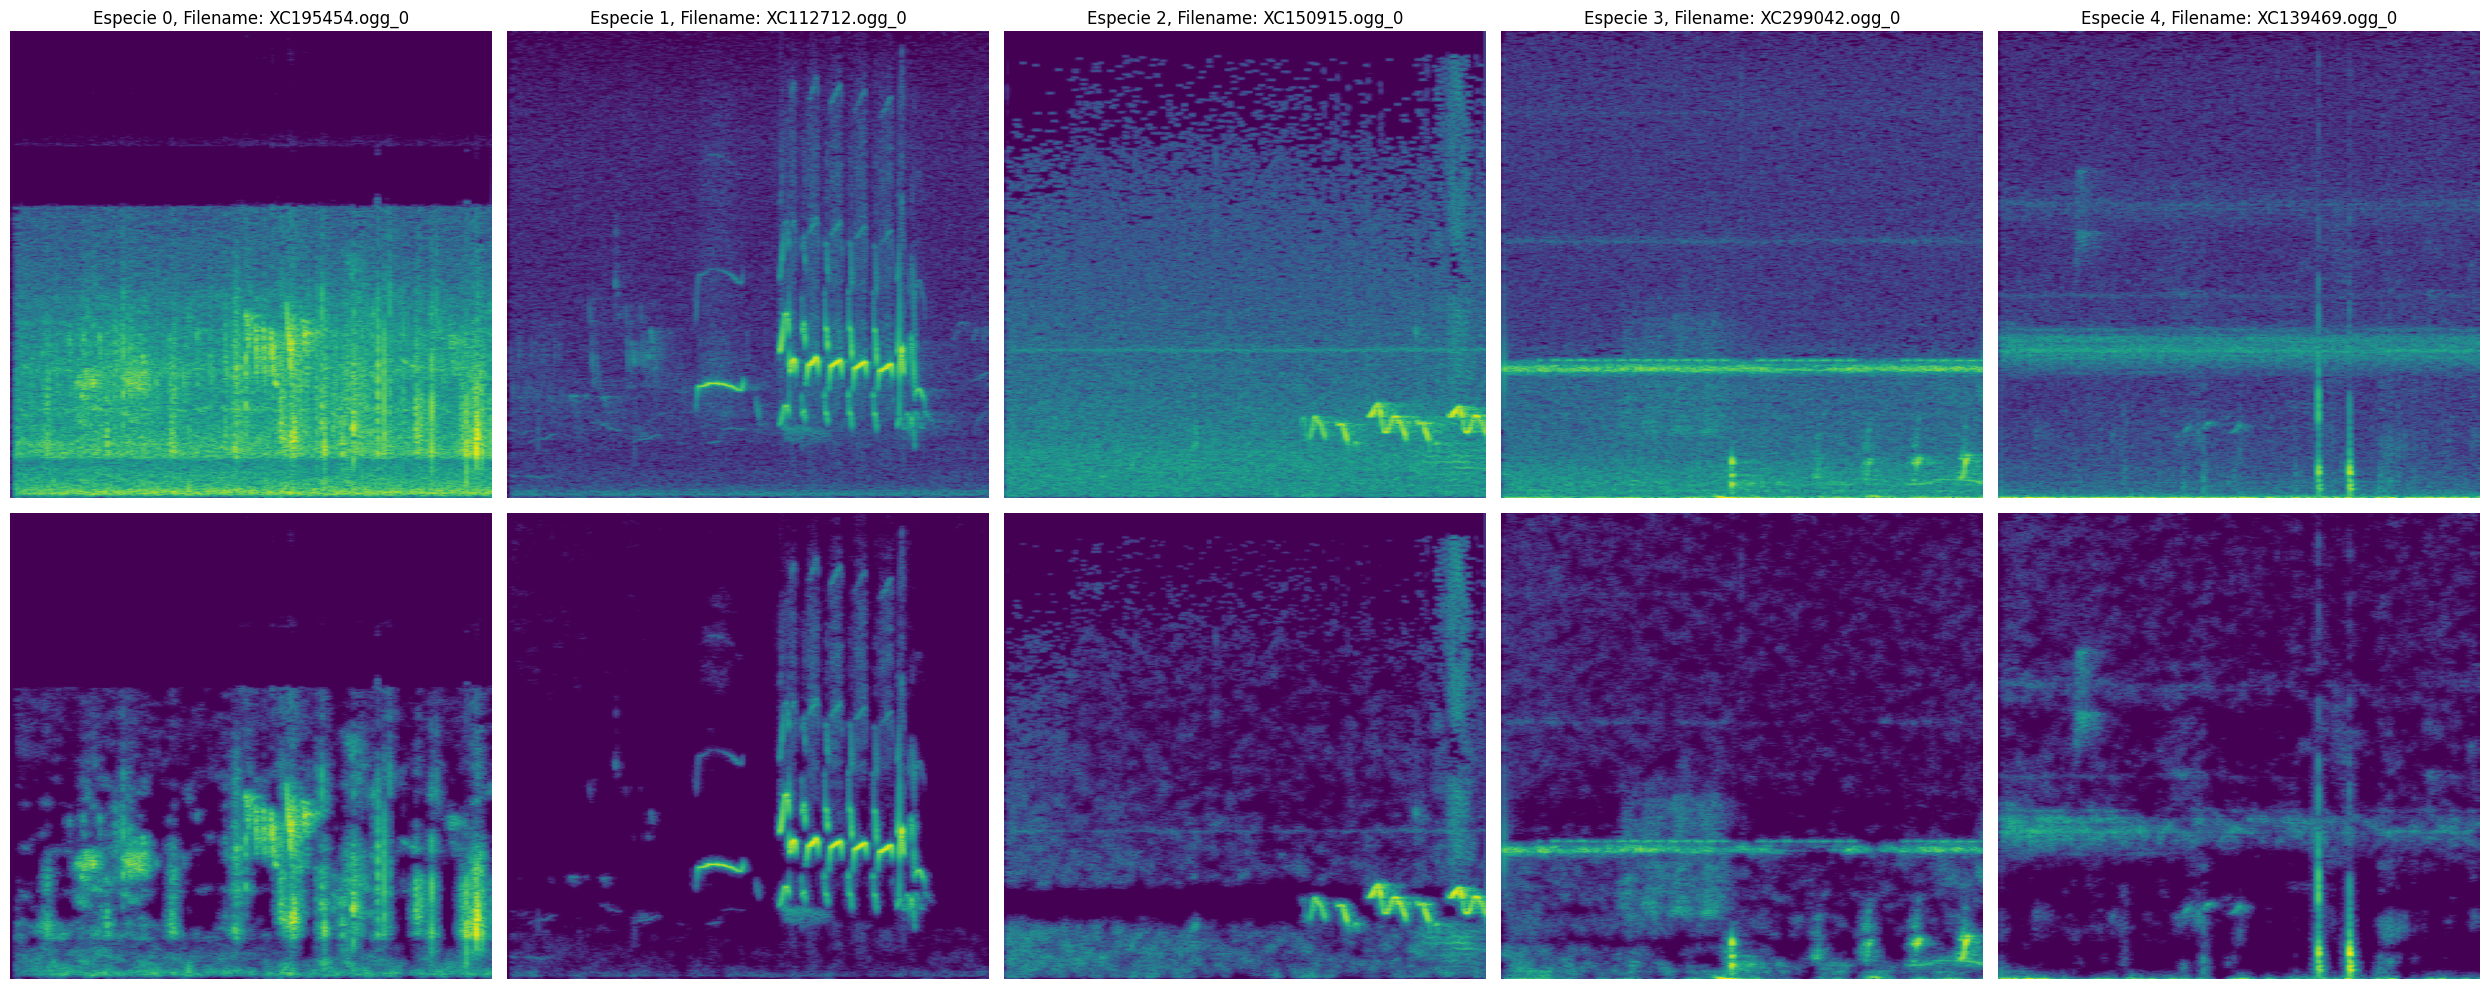

In [41]:
# Selecciona una muestra de archivos de diferentes especies
plt.figure(figsize=(25,10))
num_species = 5
species_sample = train_data.groupby('class_id').first().reset_index().head(num_species)


fig, axs = plt.subplots(2, num_species, figsize=(25, 10))
for idx, row in species_sample.iterrows():
    wav_path = os.path.join(output_dir, str(row['class_id']), f"{row['filename'].replace('.ogg', '')}_0.wav")
    wav, srate = lbrs.load(wav_path, sr=None)
    ffourier = lbrs.stft(wav)
    S_db = lbrs.amplitude_to_db(np.abs(ffourier), ref=np.max)
    
    axs[0, idx].imshow(S_db, aspect='auto', origin='lower', cmap='viridis')
    axs[0, idx].set_title(f"Especie {row['class_id']}, Filename: {row['filename']}_0")
    axs[0, idx].axis('off')

    nr_wav = nr.reduce_noise(wav, sr=32000, stationary=False)
    nr_ffourier = lbrs.stft(nr_wav)
    nr_S_db = lbrs.amplitude_to_db(np.abs(nr_ffourier), ref=np.max)
    axs[1, idx].imshow(nr_S_db, aspect='auto', origin='lower', cmap='viridis')
    axs[1, idx].axis('off')

plt.tight_layout()

plt.show()